# diagnostics_ob Example: global_ocean

For this example, we leverage the configuration from the `tutorial_global_oce_latlon` provided with the MITgcm distribution (verification/tutorial_global_oce_latlon) and described on the [MITgcm Read The Docs](https://mitgcm.readthedocs.io/en/latest/examples/global_oce_latlon/global_oce_latlon.html). This configuration simulates the planetary ocean circulation on a 4 degree grid. 

In this example, we consider the model solution particularly in a subdomain in the Pacific Ocean.

### Visualizing the domain
To view the subdomain used in the example, we can run the following code which reads in user-defined masks provided in the ```data``` directory and plots them along side of the bathymetry: 

Text(0.5, 1.0, 'Surface Mask')

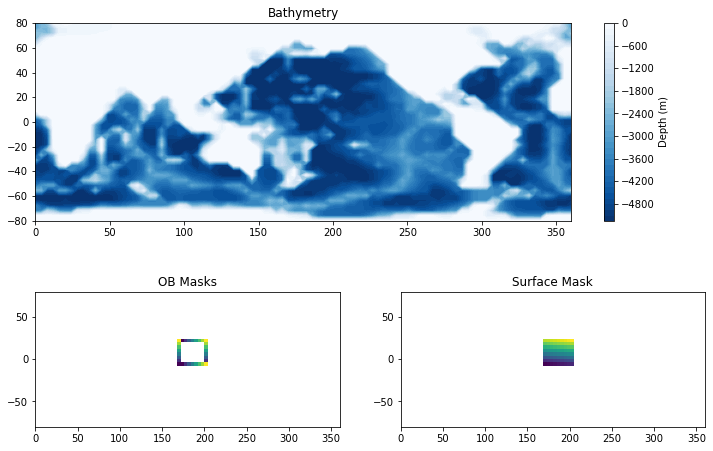

In [169]:
import numpy as np
import matplotlib.pyplot as plt
config_directory = '../../../example_configurations_compiled/global_ocean_subdomain_masks'
bathymetry = np.fromfile(config_directory+'/input/bathymetry.bin', dtype='>f4')
bathymetry = np.reshape(bathymetry,(40,90))

fig = plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
x = np.linspace(0,360,90)
y = np.linspace(-80,80,40)
C = plt.contourf(x,y,bathymetry,50,cmap='Blues_r')
cbar = plt.colorbar(C)
cbar.set_label('Depth (m)', rotation=90)
plt.title('Bathymetry')

plt.subplot(2,2,3)
for mask_name in ['boundary_mask_east','boundary_mask_west','boundary_mask_north','boundary_mask_south']:
    mask = np.fromfile(config_directory+'/input/'+mask_name+'.bin', dtype='>f4')
    mask = np.reshape(mask,(40,90))
    mask = np.ma.masked_where(mask == 0, mask)
    plt.imshow(mask,extent=[np.min(x),np.max(x),np.min(y),np.max(y)],origin='lower')
plt.title('OB Masks')

plt.subplot(2,2,4)
mask_name = 'surface_mask'
mask = np.fromfile(config_directory+'/input/'+mask_name+'.bin', dtype='>f4')
mask = np.reshape(mask,(40,90))
mask = np.ma.masked_where(mask == 0, mask)
plt.imshow(mask,extent=[np.min(x),np.max(x),np.min(y),np.max(y)],origin='lower')
plt.title('Surface Mask')

## Using this example
To use this example, copy the `diagnostics_ob` directory into `MITgcm/pkg` (i.e. `MITgcm/pkg/diagnostics_ob`)

## Configuration Code
The configuration for this example is provided in `example_configurations/global_ocean_subdomain_masks`. 

## Configuration Updates
Here, we describe the updates to the `tutorial_global_oce_latlon` tutorial:


### input
|file|description|
|-|-|
|`data`|In the `data` file, we change the time stepping parameters to run the model for 25 years (788,400,000 sec = 25 x 31,536,000 sec) and output variables at a frequency of 5 years (157,680,000 sec = 5 x 31,536,000 sec). Additionally, we turn off the `taveFreq` because the averaged field are not pertinent for this example.|
|`data.pkg`|As with any package, the diagnostics_ob package is initialized in the .pkg file with the line `useDiagnostics_ob=.TRUE.`|
|`data.diagnostics_ob`|This file contains a list of parameters that tell the diagnostic_ob package which variables to output, when and where. Here we choose an averaging period of 0.5 years (15,768,000 sec = 0.5 x 31,536,000 sec) and request output over the full 25 year (788,400,000 sec) period. The `flt32_mask1.bin` file (created below) is identified as the sampling mask. The variable `ETAN` is requested on the surface, and the variable `THETA` is requested at all 15 depth levels.|
|`boundary_mask_[direction].bin` and `surface_mask.bin`|The diagnostics_ob package requires user-defined mask(s) where the model solution will be sub-sampled. The masks count sequentially along a given boundary.|

### code
|file|description|
|-|-|
|`SIZE.h`|For this example, we will use MPI to decrease the run time of the code, so we copied over the contents of `SIZE.h_mpi` to this file and then deleted `SIZE.h_mpi`.|
|`packages.conf`|In this file, we add the `diagnostics_ob` package to the list, and delete `timeave` because we do not need the time-averaged results for this demonstration|
|all updated `model/*` files| Several model files need to be updated to include the new package. These files pertain to the boot sequence and include: `packages_boot.F`, `packages_readparms.F`, `packages_init_fixed.F`, `packages_check.F`, `packages_init_variables.F`, `do_the_model_io.F`, `packages_write_pickup.F`, and `PARAMS.h`. These codes, which have been updated here, are provided in the code folder so that they overwrite those provided in `model/src` and `model/inc` during the model run. |

## Building and Running the Configuration
### Building the model
For convenience, a shell script is provided in the `global_ocean` directory to build the model. Navigate to `example_configurations/global_ocean` in the terminal and enter `bash build.sh`. Note that you may need to update the optfile based on your system configuration.
### Running the model
For convenience, a shell script is provided in the `global_ocean` directory to run the model. Within the `example_configurations/global_ocean` directory, enter `bash run.sh`. Note that you may need to update the `mpirun` command based on your MPI configuration.

## Comparing Traditional vs Diagnostic_ob Output
After a successful model run, the `global_ocean/run` directory will contain all of the traditional MITgcm output and a few extra files generated from the `diagnostic_ob` package. 

#### Read in and define pertinent constants

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from MITgcmutils import mds

config_directory = '../../../example_configurations_compiled/global_ocean_subdomain_masks'
run_dir = config_directory+'/run'

# read in the x, y, and depth arrays
x = mds.rdmds(run_dir + '/XC*')
y = mds.rdmds(run_dir + '/YC*')
d = mds.rdmds(run_dir + '/RC')

# these are the rows/cols of the masks generated for reference
min_col = 42
max_col = 50
min_row = 18
max_row = 25

# choose a latitude, longitude and depth to compare the two output
lon_col_ob = 4 # column in ob array (for horizontal masks only)
lon_col = min_col+lon_col_ob+1 # column in global array
lat_row_ob = 0 # row in ob array (for vertical masks only)
lat_row = min_row+lat_row_ob # row in global array

depth_index = 0 # this is the surface cell
mask_number = '01' #the southern mask is the first one defined

time_step = 1 # years
n_years = 5 # total years
time_traditional = np.arange(0,n_years+1,time_step)

time_step_ob = 1/365.0 # years
time_diagnostics_ob = np.arange(time_step_ob/2,n_years,time_step_ob)

## THETA
First, we'll focus on the `THETA` variable. We can read in `THETA` from both the traditional output and the diagnostic_ob output and compare the two. First, I'll shown the comparison for one of the 4 boundary files, and then I'll show the surface.

### THETA on the Boundary
#### Comparison in space:

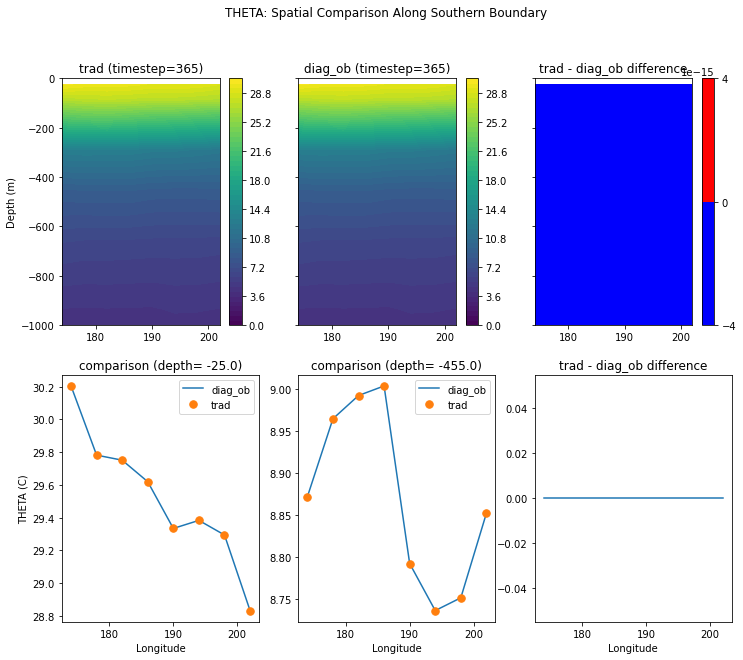

In [196]:
# read in the traditional theta output and stack into a 4D array
T_traditional = []
for year in range(0,n_years+1,time_step):
    t = mds.rdmds(run_dir + '/T*',year*365) # shape is (15,40,90)
    T_traditional.append(t)
T_traditional = np.stack(T_traditional)

# read in the theta from the diagnostics_ob output
T_diagnostics_ob = np.fromfile(run_dir+'/MASK_OB_'+mask_number+'_THETA.bin', dtype='>f4')
T_diagnostics_ob = np.reshape(T_diagnostics_ob,(365*n_years,15,max_col-min_col))

# make a comparison of the two fields
comparison_year=1
trad_subset = T_traditional[comparison_year,:,min_row,min_col+1:max_col+1]
ob_subset = T_diagnostics_ob[comparison_year*365-1,:,:]

# get the bounds of the subset
lon_subset = x[min_row,min_col+1:max_col+1]
depth = d[:,0,0]

# plot everything
plt.figure(figsize=(12,10))

plt.subplot(2,3,1)
C0=plt.contourf(lon_subset,depth,trad_subset,50)
plt.colorbar(C0)
plt.gca().set_ylim([-1000,0])
plt.ylabel('Depth (m)')
plt.title('trad (timestep='+str(365*comparison_year)+')')

plt.subplot(2,3,2)
C1=plt.contourf(lon_subset,depth,ob_subset,50)
plt.colorbar(C1)
plt.gca().set_ylim([-1000,0])
plt.title('diag_ob (timestep='+str(365*comparison_year)+')')
plt.gca().set_yticklabels([])

plt.subplot(2,3,3)
C2=plt.contourf(lon_subset,depth,trad_subset-ob_subset,50,cmap='seismic')
plt.colorbar(C2)
plt.gca().set_ylim([-1000,0])
plt.gca().set_yticklabels([])
plt.title('trad - diag_ob difference')

plt.subplot(2,3,4)
plt.plot(lon_subset,ob_subset[0,:],'-',label='diag_ob')
plt.plot(lon_subset,trad_subset[0,:],'.',label='trad',markersize=15)
plt.title('comparison (depth= '+str(depth[0])+')')
plt.ylabel('THETA (C)')
plt.xlabel('Longitude')
plt.legend()

plt.subplot(2,3,5)
plt.plot(lon_subset,ob_subset[4,:],'-',label='diag_ob')
plt.plot(lon_subset,trad_subset[4,:],'.',label='trad',markersize=15)
plt.title('comparison (depth= '+str(depth[4])+')')
plt.xlabel('Longitude')
plt.legend()

plt.subplot(2,3,6)
plt.plot(lon_subset,trad_subset[0,:]-ob_subset[0,:])
plt.title('trad - diag_ob difference')
plt.xlabel('Longitude')

plt.suptitle('THETA: Spatial Comparison Along Southern Boundary')

plt.show()



#### Comparison in Time

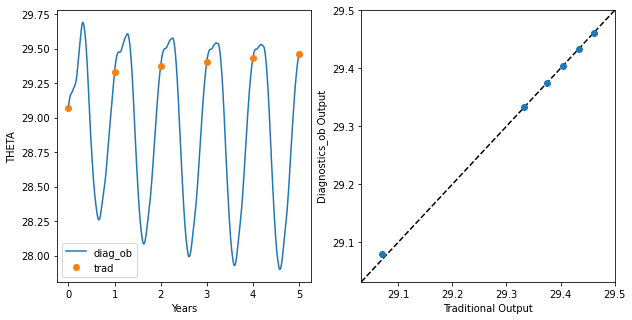

In [197]:
# read in the traditional theta output and stack into a 4D array
T_traditional = []
for year in range(0,n_years+1,time_step):
    t = mds.rdmds(run_dir + '/T*',year*365) # shape is (15,40,90)
    T_traditional.append(t)
T_traditional = np.stack(T_traditional)

# read in the theta from the diagnostics_ob output
T_diagnostics_ob = np.fromfile(run_dir+'/MASK_OB_'+mask_number+'_THETA.bin', dtype='>f4')
T_diagnostics_ob = np.reshape(T_diagnostics_ob,(365*n_years,15,max_col-min_col))

# sample the outputs on the same points
T_traditional = T_traditional[:,depth_index,lat_row,lon_col]
T_diagnostics_ob = T_diagnostics_ob[:,depth_index,lon_col_ob]

# find the T points in diagnostics_ob at near the same time as the traditional output
# the first point is omitted because the model is rapidly adjusting in this time
# and the diagnostic_ob packages averages the output daily
T_diagnostics_ob_coincident = []
for year in time_traditional:
    T_diagnostics_ob_coincident.append(T_diagnostics_ob[np.argmin(np.abs(year-time_diagnostics_ob))])
    
# make a comparison plot of the two variables
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(time_diagnostics_ob,T_diagnostics_ob,label='diag_ob')
plt.plot(time_traditional,T_traditional,'o',label='trad')
plt.gca().set_ylabel('THETA')
plt.gca().set_xlabel('Years')
plt.legend()

plt.subplot(1,2,2)
min_val = np.min([np.min(T_traditional),np.min(T_diagnostics_ob_coincident)])
max_val = np.max([np.max(T_traditional),np.max(T_diagnostics_ob_coincident)])
val_range = max_val-min_val
plt.plot([min_val-0.1*val_range,max_val+0.1*val_range],[min_val-0.1*val_range,max_val+0.1*val_range],'k--')
plt.plot(T_traditional,T_diagnostics_ob_coincident,'o')
plt.gca().set_xlim([min_val-0.1*val_range,max_val+0.1*val_range])
plt.gca().set_ylim([min_val-0.1*val_range,max_val+0.1*val_range])
plt.gca().set_ylabel('Diagnostics_ob Output')
plt.gca().set_xlabel('Traditional Output')
plt.show()

### THETA on the Surface

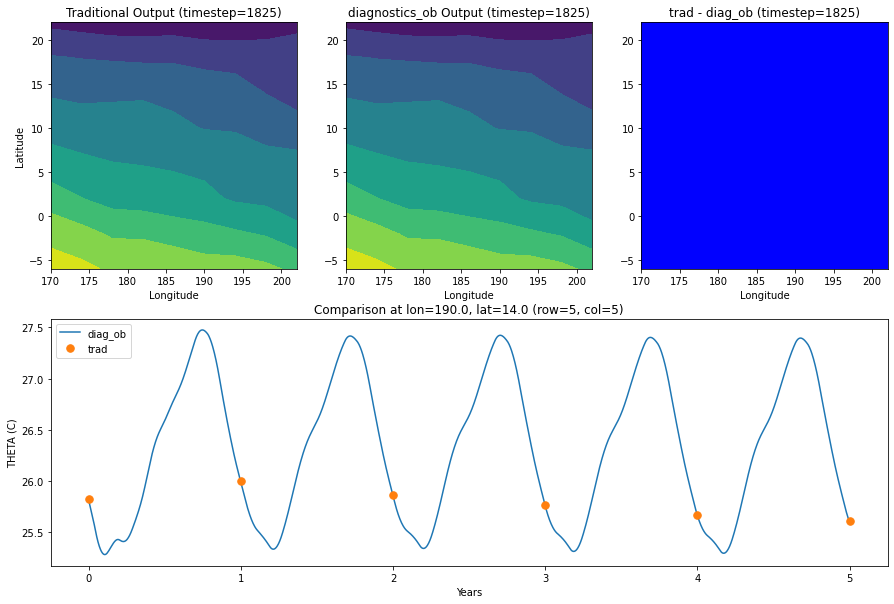

In [192]:
# read in the traditional theta output and stack into a 4D array
T_traditional = []
for year in range(0,n_years+1,time_step):
    t = mds.rdmds(run_dir + '/T*',year*365) # shape is (15,40,90)
    T_traditional.append(t)
T_traditional = np.stack(T_traditional)
T_traditional = T_traditional[:,0,:,:]

# read in the theta from the diagnostics_ob output
T_diagnostics_sf = np.fromfile(run_dir+'/MASK_SF_01_THETA.bin', dtype='>f4')
T_diagnostics_sf = np.reshape(T_diagnostics_sf,(365*n_years,max_row-min_row+1,max_col-min_col+1))

fig = plt.figure(figsize=(15,10))

year = 5
row = 5
col = 5

lon_subset = x[min_row,min_col:max_col+1]
lat_subset = y[min_row:max_row+1,min_col]

plt.subplot(2,3,1)
trad_subset = T_traditional[year,min_row:max_row+1,min_col:max_col+1]
plt.contourf(lon_subset,lat_subset,trad_subset)
plt.title('Traditional Output (timestep='+str(365*year)+')')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.subplot(2,3,2)
diag_subset = T_diagnostics_sf[year*365-1,:,:]
plt.contourf(lon_subset,lat_subset,diag_subset)
plt.title('diagnostics_ob Output (timestep='+str(365*year)+')')
plt.xlabel('Longitude')

plt.subplot(2,3,3)
diag_subset = T_diagnostics_sf[year*365-1,:,:]
plt.contourf(lon_subset,lat_subset,trad_subset - diag_subset,cmap='seismic')
plt.title('trad - diag_ob (timestep='+str(365*year)+')')
plt.xlabel('Longitude')

plt.subplot(2,1,2)
trad_timeseries = T_traditional[:,min_row+row,min_col+col]
diag_timeseries = T_diagnostics_sf[:,row,col]
plt.plot(time_diagnostics_ob,diag_timeseries,label='diag_ob')
plt.plot(time_traditional,trad_timeseries,'.',markersize=15,label='trad')
plt.title('Comparison at lon='+str(lon_subset[col])+', lat='+str(lat_subset[row])+' (row='+str(row)+', col='+str(col)+')')
plt.legend()
plt.xlabel('Years')
plt.ylabel('THETA (C)')


plt.show()

### ETAN
Next, we'll take a look at the `ETAN` variable. Recall that this is a 2D field in the model but `diagnostics_ob` outputs the field along the 1D line shown in the domain figure.

### ETAN on the boundary

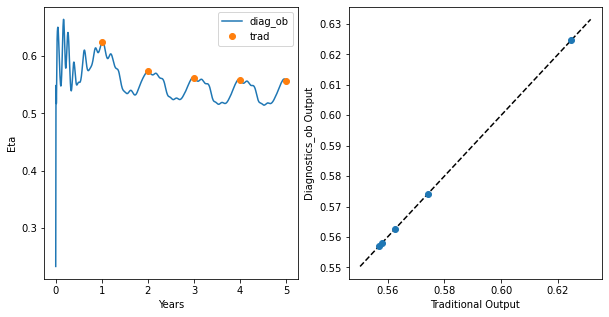

In [198]:
# read in the traditional eta output and stack into a 3D array (time, rows, cols)
eta_traditional = []
for year in range(0,n_years+1,time_step):
    t = mds.rdmds(run_dir + '/Eta*',year*365) # shape is (40,90)
    eta_traditional.append(t)
eta_traditional = np.stack(eta_traditional)

# read in the eta from the diagnostics_ob output
eta_diagnostics_ob = np.fromfile(run_dir+'/MASK_OB_'+mask_number+'_ETAN.bin', dtype='>f4')
eta_diagnostics_ob = np.reshape(eta_diagnostics_ob,(365*n_years,max_col-min_col))

# make a comparison of the two
eta_traditional = eta_traditional[:,lat_row,lon_col]
eta_diagnostics_ob = eta_diagnostics_ob[:,lon_col_ob]

# find the eta points in diagnostics_ob at near the same time as the traditional output
# the first point is omitted because the model is rapidly adjusting in this time
eta_diagnostics_ob_coincident = []
for year in time_traditional[1:]:
    eta_diagnostics_ob_coincident.append(eta_diagnostics_ob[np.argmin(np.abs(year-time_diagnostics_ob))])

# make a comparison plot of the two variables
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(time_diagnostics_ob,eta_diagnostics_ob,label='diag_ob')
plt.plot(time_traditional[1:],eta_traditional[1:],'o',label='trad')
plt.gca().set_ylabel('Eta')
plt.gca().set_xlabel('Years')
plt.legend()

plt.subplot(1,2,2)
min_eta = np.min([np.min(eta_traditional[1:]),np.min(eta_diagnostics_ob_coincident)])
max_eta = np.max([np.max(eta_traditional[1:]),np.min(eta_diagnostics_ob_coincident)])
eta_range = max_eta-min_eta
plt.plot([min_eta-0.1*eta_range,max_eta+0.1*eta_range],[min_eta-0.1*eta_range,max_eta+0.1*eta_range],'k--')
plt.plot(eta_traditional[1:],eta_diagnostics_ob_coincident,'o')
plt.gca().set_ylabel('Diagnostics_ob Output')
plt.gca().set_xlabel('Traditional Output')

plt.show()

### ETAN on the (whole domain of the) Surface

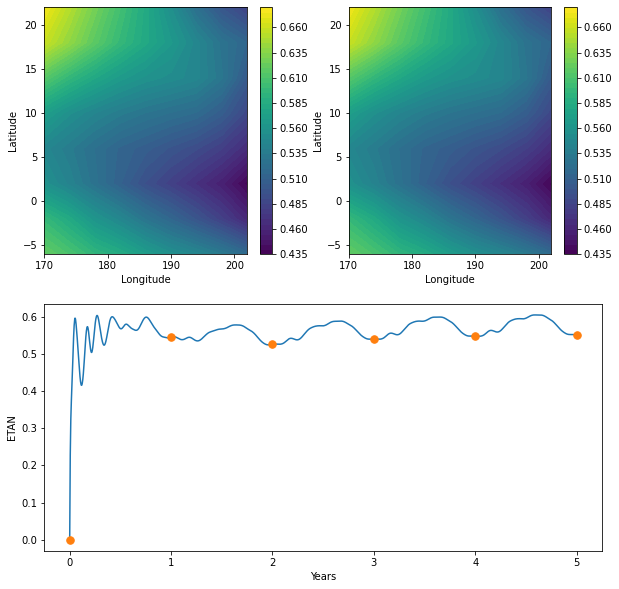

In [201]:
# read in the traditional etan output and stack into a 3D array
T_traditional = []
for year in range(0,n_years+1,time_step):
    t = mds.rdmds(run_dir + '/Eta*',year*365) # shape is (40,90)
    T_traditional.append(t)
T_traditional = np.stack(T_traditional)

T_diagnostics_sf = np.fromfile(run_dir+'/MASK_SF_01_ETAN.bin', dtype='>f4')
T_diagnostics_sf = np.reshape(T_diagnostics_sf,(365*n_years,max_row-min_row+1,max_col-min_col+1))

fig = plt.figure(figsize=(10,10))
year = 5

row = 5
col = 5
lon_subset = x[min_row,min_col:max_col+1]
lat_subset = y[min_row:max_row+1,min_col]

plt.subplot(2,2,1)
trad_subset = T_traditional[year,min_row:max_row+1,min_col:max_col+1]
C = plt.contourf(lon_subset,lat_subset,trad_subset,50)
plt.colorbar(C)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.subplot(2,2,2)
diag_subset = T_diagnostics_sf[year*365-1,:,:]
C2 = plt.contourf(lon_subset,lat_subset,diag_subset,50)
plt.colorbar(C2)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.subplot(2,1,2)
trad_timeseries = T_traditional[:,min_row+row,min_col+col]
diag_timeseries = T_diagnostics_sf[:,row,col]
plt.plot(time_diagnostics_ob,diag_timeseries,label='diag_ob')
plt.plot(time_traditional,trad_timeseries,'.',markersize=15,label='time')
plt.xlabel('Years')
plt.ylabel('ETAN')

plt.show()